In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
import gzip
import time
import csv
import math

In [2]:
Hidden_size = 100
Batch_size = 256
N_layer = 2
N_epoch = 50
N_chars = 128
Use_GPU = False

In [3]:
class NameDataset(Dataset):
    def __init__(self, is_train_set=True):
        filename = "D:/python/深度学习/data/names_train.csv.gz" if is_train_set else "D:/python/深度学习/data/names_test.csv.gz"
        with gzip.open(filename, 'rt') as f:
            reader = csv.reader(f)
            rows = list(reader)
        self.name = [row[0] for row in rows]
        self.len = len(self.name)
        self.countries = [row[1] for row in rows]
        self.country_list = list(sorted(set(self.countries)))
        self.country_dict = self.getCountryDict()
        self.country_num = len(self.country_list)

    def __getitem__(self, index):
        return self.name[index], self.country_dict[self.countries[index]]
    
    def __len__(self):
        return self.len
    
    def getCountryDict(self):
        country_dict = dict()
        for idx, country_name in enumerate(self.country_list):
            country_dict[country_name] = idx
        return country_dict
    
    def idx2country(self, index):
        return self.country_list[index]
    
    def getCountryNum(self):
        return self.country_num


In [4]:
trainset = NameDataset(is_train_set=True)
trainloader = DataLoader(trainset, batch_size=Batch_size, shuffle=True)
testset = NameDataset(is_train_set=False)
testloader = DataLoader(testset, batch_size=Batch_size, shuffle=True)

N_country = trainset.getCountryNum()

In [5]:
class RNNClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layer = 1, bidirectional = True):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_layer = n_layer
        self.n_directions = 2 if bidirectional else 1

        self.embedding = torch.nn.Embedding(input_size, hidden_size)
        self.gru = torch.nn.GRU(hidden_size, hidden_size, n_layer, bidirectional=bidirectional)
        self.fc = torch.nn.Linear(hidden_size * self.n_directions, output_size)

    def __init__hidden(self, batch_size):
        hidden = torch.zeros(self.n_layer * self.n_directions, batch_size, self.hidden_size)
        if Use_GPU:  
            hidden = hidden.to(torch.device("cuda:0"))  
        return hidden  
    
    def forward(self, input, seq_lengths):
        #input shape B * S -> S * B
        input = input.t()
        batch_size = input.size(1)

        hidden = self.__init__hidden(batch_size)
        embedding = self.embedding(input)

        #pack them up
        gru_input = torch.nn.utils.rnn.pack_padded_sequence(embedding, seq_lengths)

        output, hidden = self.gru(gru_input, hidden)
        if self.n_directions == 2:  
            # 注意：这里可能需要根据您的PyTorch版本调整hidden的形状处理  
            hidden_cat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)  
        else:  
            hidden_cat = hidden[-1, :, :]  
        fc_output = self.fc(hidden_cat)
        return fc_output
    



In [6]:
def name2list(name):
    arr = [ord(c) for c in name]
    return arr, len(arr)

def create_tensor(tensor):
    if Use_GPU:
        device = torch.device("cuda:0")
        tensor = tensor.to(device)
    return tensor

def make_tensors(names, countries):
    sequences_and_lengths = [name2list(name) for name in names]
    name_seequences = [s1[0] for s1 in sequences_and_lengths]
    seq_lengths = torch.LongTensor([s1[1] for s1 in sequences_and_lengths])
    countries = countries.long()

    #make tensor of name, BatchSize * SeqLen
    seq_tensor = torch.zeros(len(name_seequences), seq_lengths.max()).long()
    for idx, (seq, seq_len) in enumerate(zip(name_seequences, seq_lengths), 0):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)

    #sort by length to use pack_padded_sequence
    seq_lengths, perm_idx = seq_lengths.sort(dim=0, descending=True)
    seq_tensor = seq_tensor[perm_idx]
    countries = countries[perm_idx]

    return create_tensor(seq_tensor), create_tensor(seq_lengths), create_tensor(countries)

In [7]:
def trainModel():
    total_loss = 0
    for i, (names, countries) in enumerate(trainloader, 1):
        inputs, seq_lengths, target = make_tensors(names, countries)
        optimizer.zero_grad()
        output = classifier(inputs, seq_lengths)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if i %10 == 0:
            print(f'[{time_since(start)}] Epoch {epoch}', end='')
            print(f'[{i * len(inputs)}/{len(trainset)}]', end='')
            print(f', Loss={total_loss / (i * len(inputs)):.4f}')
    return total_loss

In [8]:
def testModel():
    correct = 0
    total = len(testset)
    print("evaluating trained model ...")
    with torch.no_grad():
        for i, (names, countries) in enumerate(testloader, 1):
            inputs, seq_lengths, target = make_tensors(names, countries)
            output = classifier(inputs, seq_lengths)
            pred = output.max(dim=1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        percent = '%.2f' % (100 * correct / total)
        print(f'Test set: Accuracy {correct}/{total} {percent}%')
    return correct / total

In [9]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
    

if __name__ == '__main__':
    classifier = RNNClassifier(N_chars, Hidden_size, N_country, N_layer)
    if Use_GPU:
        device = torch.device("cuda:0")
        classifier.to(device) 

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

    start = time.time()
    print("Training for %d epochs..." % N_epoch)
    acc_list = []
    for epoch in range(1, N_epoch + 1):
        trainModel()
        acc = testModel()
        acc_list.append(acc)

Training for 50 epochs...
 1s] Epoch 1[2560/13374], Loss=0.0088
 3s] Epoch 1[5120/13374], Loss=0.0076
 4s] Epoch 1[7680/13374], Loss=0.0069
 6s] Epoch 1[10240/13374], Loss=0.0064
 8s] Epoch 1[12800/13374], Loss=0.0061
evaluating trained model ...
Test set: Accuracy 4530/6700 67.61%
 11s] Epoch 2[2560/13374], Loss=0.0042
 12s] Epoch 2[5120/13374], Loss=0.0041
 14s] Epoch 2[7680/13374], Loss=0.0040
 16s] Epoch 2[10240/13374], Loss=0.0039
 17s] Epoch 2[12800/13374], Loss=0.0038
evaluating trained model ...
Test set: Accuracy 4989/6700 74.46%
 20s] Epoch 3[2560/13374], Loss=0.0031
 22s] Epoch 3[5120/13374], Loss=0.0031
 24s] Epoch 3[7680/13374], Loss=0.0030
 25s] Epoch 3[10240/13374], Loss=0.0030
 27s] Epoch 3[12800/13374], Loss=0.0030
evaluating trained model ...
Test set: Accuracy 5209/6700 77.75%
 30s] Epoch 4[2560/13374], Loss=0.0028
 31s] Epoch 4[5120/13374], Loss=0.0027
 33s] Epoch 4[7680/13374], Loss=0.0026
 35s] Epoch 4[10240/13374], Loss=0.0025
 36s] Epoch 4[12800/13374], Loss=0.0

In [10]:
import matplotlib.pyplot as plt
import numpy as np

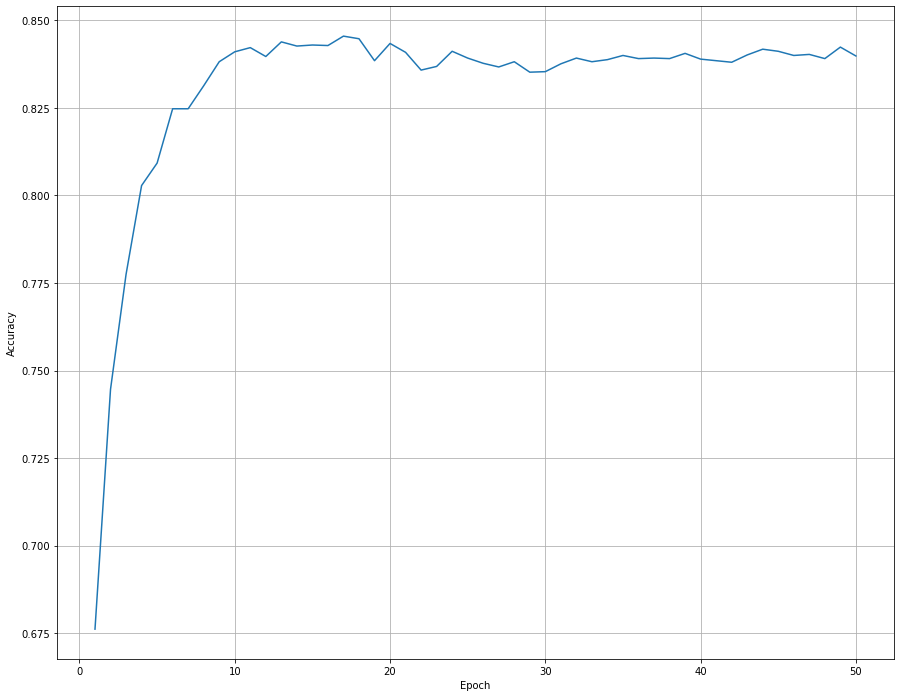

In [11]:
epoch = np.arange(1, len(acc_list) + 1, 1)
acc_list = np.array(acc_list)
plt.figure(figsize=(15, 12))
plt.plot(epoch, acc_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()